# Classificatino models

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
from utils.helper import read_data
import utils.processing as processing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
FOLDER = "data/"
SAMPLE_SIZE = 1000
N_STATIC = 3
N_MOVING = 3

## Data preprocessing

Here we are reading the data from the files and combining the phases of size **SAMPLE_SIZE**. 

In [2]:
data_static = [read_data(FOLDER + "data_static_100_s_" + str(i+1) + ".csv") for i in range(N_STATIC)]
data_moving = [read_data(FOLDER + "data_moving_100_s_" + str(i+1) + ".csv") for i in range(N_MOVING)]
print(f"Shape one of three static datas: {data_static[0].shape}")
print(f"Shape one of three moving datas: {data_moving[0].shape}")

Shape one of three static datas: (3, 100000, 64)
Shape one of three moving datas: (3, 100000, 64)


Here we are splitting the 100s into 100 samples of one second each. With 3 measurements of moving and 3 measurements of static object we obtain 600 samples for a classification task.

In [3]:
from utils.helper import calculate_phases
phases_static = calculate_phases(data_static, N_STATIC, SAMPLE_SIZE)
phases_moving = calculate_phases(data_moving, N_STATIC, SAMPLE_SIZE)
print(f"Shape static phases: {phases_static.shape}")
print(f"Shape moving phases: {phases_moving.shape}")

train_data = np.concatenate((phases_static, phases_moving))
print(f"Shape train data: {train_data.shape}")

Shape static phases: (300, 1000)
Shape moving phases: (300, 1000)
Shape train data: (600, 1000)


Now we need to create labels for the training data.

In [4]:
indexes = np.arange(train_data.shape[0])
train_labels = indexes >= train_data.shape[0]/2
print("Shape train labels:", train_labels.shape)
nb_classes = 2
train_labels_one_hot = np.eye(nb_classes)[train_labels.astype(int)]
print("Shape train labels one hot:", train_labels_one_hot.shape)

Shape train labels: (600,)
Shape train labels one hot: (600, 2)


(Optional) Average the data make less input into a NN, so that less neurons would be needed to learn.

Shape train data av: (600, 50)
Shape train data: (600, 1000)


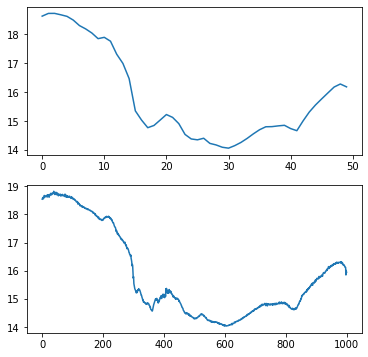

In [5]:
from utils.helper import avarage_phases
train_data_av = avarage_phases(train_data)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))
print(f"Shape train data av: {train_data_av.shape}")
print(f"Shape train data: {train_data.shape}")
ax1.plot(train_data_av[5])
ax2.plot(train_data[5])

Do the split of the data in a train and test set.

Look at some random samples of the train data and their labels.

Index random: [500 321 591]


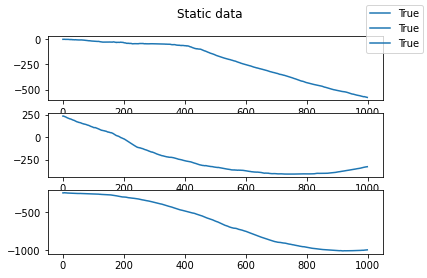

In [6]:
index_random = np.random.randint(600, size = 3)
print(f"Index random: {index_random}")
fig, axs = plt.subplots(3)
fig.suptitle('Static data')
for i, ax in zip(index_random, axs):
    ax.plot(train_data[i], label=f'{train_labels[i]}')
fig.legend()

## Model

### Simple Threshold classifier

In [7]:
from sklearn.metrics import classification_report
means = np.mean(train_data, axis=1)
classified_data = means > 50 # False = not moving True = moving

print(classification_report(train_labels, classified_data))

              precision    recall  f1-score   support

       False       0.65      1.00      0.78       300
        True       1.00      0.45      0.62       300

    accuracy                           0.73       600
   macro avg       0.82      0.72      0.70       600
weighted avg       0.82      0.72      0.70       600



### Simple MLP classifier

In [8]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(train_data_av, train_labels, test_size=0.1)
print(f"Shape train_X: {train_X.shape}")
print(f"Shape test_X: {test_X.shape}")
print(f"Shape train_y: {train_y.shape}")
print(f"Shape test_y: {test_y.shape}")

Shape train_X: (540, 50)
Shape test_X: (60, 50)
Shape train_y: (540,)
Shape test_y: (60,)


In [9]:
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metric
import numpy as np
from sklearn.model_selection import GridSearchCV

#create the corresponding net with the MLP classifier
nn_model = MLPClassifier(activation = "relu", hidden_layer_sizes=(5), solver = "adam", early_stopping=True, n_iter_no_change = 25, alpha = 0.01, verbose = 2)
nn_model.fit(train_X, train_y)

Iteration 1, loss = 6.43339426
Validation score: 0.444444
Iteration 2, loss = 5.03438992
Validation score: 0.425926
Iteration 3, loss = 4.63150922
Validation score: 0.407407
Iteration 4, loss = 4.25725061
Validation score: 0.425926
Iteration 5, loss = 3.85127023
Validation score: 0.425926
Iteration 6, loss = 3.66228200
Validation score: 0.444444
Iteration 7, loss = 3.54899905
Validation score: 0.444444
Iteration 8, loss = 3.45485026
Validation score: 0.444444
Iteration 9, loss = 3.32723250
Validation score: 0.462963
Iteration 10, loss = 3.21831346
Validation score: 0.462963
Iteration 11, loss = 3.05256351
Validation score: 0.462963
Iteration 12, loss = 2.91521949
Validation score: 0.481481
Iteration 13, loss = 2.69365033
Validation score: 0.481481
Iteration 14, loss = 2.58259820
Validation score: 0.500000
Iteration 15, loss = 2.37058987
Validation score: 0.518519
Iteration 16, loss = 2.20799349
Validation score: 0.555556
Iteration 17, loss = 2.13618587
Validation score: 0.555556
Iterat

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=5,
              n_iter_no_change=25, verbose=2)

In [10]:
y_pred_nn = nn_model.predict(test_X)
print(classification_report(test_y, y_pred_nn))

              precision    recall  f1-score   support

       False       0.76      0.61      0.68        31
        True       0.66      0.79      0.72        29

    accuracy                           0.70        60
   macro avg       0.71      0.70      0.70        60
weighted avg       0.71      0.70      0.70        60



### 1D CNN classifier

In [60]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(train_data, train_labels_one_hot, test_size=0.1)
print(f"Shape train_X: {train_X.shape}")
print(f"Shape test_X: {test_X.shape}")
print(f"Shape train_y: {train_y.shape}")
print(f"Shape test_y: {test_y.shape}")

Shape train_X: (540, 1000)
Shape test_X: (60, 1000)
Shape train_y: (540, 2)
Shape test_y: (60, 2)


In [61]:
models = keras.models
layers = keras.layers

model = models.Sequential(
    [
        layers.Conv1D(8,
                      input_shape = (1000,1),
                      kernel_size = 10,
                      padding = "same",
                      activation = "relu"),
        layers.MaxPooling1D(2,
                            strides = None,
                            padding = "valid"),
        layers.Flatten(),
        layers.Dense(2),
        layers.Activation("softmax")
    ]
)
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 1000, 8)           88        
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 500, 8)           0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 4000)              0         
                                                                 
 dense_12 (Dense)            (None, 2)                 8002      
                                                                 
 activation_12 (Activation)  (None, 2)                 0         
                                                                 
Total params: 8,090
Trainable params: 8,090
Non-trainable params: 0
___________________________________________________

In [62]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(lr = 0.001),
    metrics = ['accuracy']
)

model.fit(
    train_X, train_y,
    epochs  = 10,
    verbose = 2,
    validation_split = 0.1,
    shuffle= True,
    callbacks=keras.callbacks.EarlyStopping(patience = 10)
)

model.save('models/CNN')


Epoch 1/10


/Users/kostiantynlavronenko/Desktop/Eestech/hackathon-private/venv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


16/16 - 0s - loss: 17.6452 - accuracy: 0.4712 - val_loss: 13.3904 - val_accuracy: 0.5741 - 460ms/epoch - 29ms/step
Epoch 2/10
16/16 - 0s - loss: 8.5792 - accuracy: 0.4856 - val_loss: 5.4800 - val_accuracy: 0.5741 - 74ms/epoch - 5ms/step
Epoch 3/10
16/16 - 0s - loss: 2.7767 - accuracy: 0.4856 - val_loss: 0.8950 - val_accuracy: 0.6111 - 75ms/epoch - 5ms/step
Epoch 4/10
16/16 - 0s - loss: 0.5798 - accuracy: 0.6543 - val_loss: 0.4410 - val_accuracy: 0.7778 - 73ms/epoch - 5ms/step
Epoch 5/10
16/16 - 0s - loss: 0.4583 - accuracy: 0.7593 - val_loss: 0.3237 - val_accuracy: 0.8704 - 69ms/epoch - 4ms/step
Epoch 6/10
16/16 - 0s - loss: 0.5094 - accuracy: 0.8230 - val_loss: 1.2301 - val_accuracy: 0.6111 - 73ms/epoch - 5ms/step
Epoch 7/10
16/16 - 0s - loss: 0.9450 - accuracy: 0.6173 - val_loss: 0.9703 - val_accuracy: 0.6296 - 75ms/epoch - 5ms/step
Epoch 8/10
16/16 - 0s - loss: 0.8710 - accuracy: 0.6420 - val_loss: 0.3165 - val_accuracy: 0.8704 - 72ms/epoch - 5ms/step
Epoch 9/10
16/16 - 0s - loss: 0

In [63]:
loss, aacuracy = model.evaluate(test_X, test_y)
print(f"Loss: {loss}")
print(f"Accuracy: {aacuracy}")

2/2 [==============================] - 0s 3ms/step - loss: 0.2801 - accuracy: 0.9333
Loss: 0.28007271885871887
Accuracy: 0.9333333373069763
